In [135]:
from dataclasses import dataclass

from pathlib import Path

import numpy as np

import random

import albumentations as aug

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.utils import Sequence
from tensorflow.keras.metrics import MeanIoU, AUC
from tensorflow.keras.callbacks import (
    Callback,
    ModelCheckpoint,
    EarlyStopping,
    ReduceLROnPlateau,
    TensorBoard,
)
from tensorflow.keras.models import load_model
from tensorflow.keras.backend import clear_session
from tensorflow.keras.preprocessing.image import load_img, img_to_array

import matplotlib.pyplot as plt


In [136]:
original_size = (2048, 1024)

size_pixels = 128
img_size = (size_pixels, size_pixels)
num_classes = 8
batch_size = 32

# Image augmentation : None for no augmentation
augment = aug.Compose(
    [
        # aug.OneOf(  # Weather augmentations
        #     [
        #         aug.RandomRain(),
        #         aug.RandomFog(),
        #         aug.RandomShadow(),
        #         aug.RandomSnow(),
        #         aug.RandomSunFlare(),
        #     ]
        # ),
        aug.OneOf(  # Color augmentations
            [
                aug.RandomBrightnessContrast(),
                aug.RandomGamma(),
                aug.RandomToneCurve(),
            ]
        ),
        aug.OneOf(  # Camera augmentations
            [
                aug.MotionBlur(),
                aug.GaussNoise(),
            ]
        ),
        aug.OneOf(  # Geometric augmentations
            [
                aug.HorizontalFlip(),
                aug.RandomCrop(
                    width=int(img_size[0] / random.uniform(1.0, 3.0)),
                    height=int(img_size[1] / random.uniform(1.0, 3.0)),
                ),
                aug.SafeRotate(
                    limit=15,
                ),
            ]
        ),
        aug.Resize(
            width=img_size[0],
            height=img_size[1],
        ),
    ]
)

model_name = (
    f"unet_xception_{size_pixels}{'_augmented' if augment is not None else ''}"
)
model_path = Path("./../results/", model_name)


In [137]:
@dataclass(frozen=True)
class CityscapesCategory:
    """Cityscapes categories.

    Attributes:
        id: The category id
        name: The category name
        color: The category color
    """

    id: int
    name: str
    color_rgb: tuple[int, int, int]
    label_ids: list[int]


# Cityscape categories
CITYSCAPES_CATEGORIES = [
    CityscapesCategory(
        0,
        "void",
        (0, 0, 0),  # black
        list(range(0, 7)),
    ),
    CityscapesCategory(
        1,
        "flat",
        (128, 64, 128),  # purple
        list(range(7, 11)),
    ),
    CityscapesCategory(
        2,
        "construction",
        (70, 70, 70),  # dark gray
        list(range(11, 17)),
    ),
    CityscapesCategory(
        3,
        "object",
        (153, 153, 153),  # light gray
        list(range(17, 21)),
    ),
    CityscapesCategory(
        4,
        "nature",
        (107, 142, 35),  # olive
        list(range(21, 23)),
    ),
    CityscapesCategory(
        5,
        "sky",
        (70, 130, 180),  # blue
        list(range(23, 24)),
    ),
    CityscapesCategory(
        6,
        "human",
        (220, 20, 60),  # crimson
        list(range(24, 26)),
    ),
    CityscapesCategory(
        7,
        "vehicle",
        (0, 0, 142),  # navy
        [-1] + list(range(26, 34)),
    ),
]


def cityscapes_label_ids_to_category_ids(img: np.array) -> np.array:
    """Convert cityscapes label ids to category ids.

    Args:
        img: Cityscapes label ids image

    Returns:
        Category ids image
    """
    if not len(img.shape) == 2:
        raise ValueError("Image must be of shape (H, W).")

    category_ids = np.zeros(img.shape, dtype=np.uint8)

    for category in CITYSCAPES_CATEGORIES:
        for label_id in category.label_ids:
            category_ids[img == label_id] = category.id

    return category_ids


def cityscapes_category_ids_to_category_colors(img: np.array) -> np.array:
    """Convert cityscapes category ids to colors.

    Args:
        img: Cityscapes category ids image

    Returns:
        Category colors image
    """
    if not len(img.shape) == 2:
        raise ValueError("Image must be of shape (H, W).")

    category_colors = np.zeros(img.shape + (3,), dtype=np.uint8)

    for row in range(img.shape[0]):
        for col in range(img.shape[1]):
            category_colors[row, col] = CITYSCAPES_CATEGORIES[
                img[row, col]
            ].color_rgb

    return category_colors


In [138]:
# Train dataset
raw_data_path = Path("./../data/raw")
leftImg8bit_path = Path(raw_data_path, "leftImg8bit")
gtFine_path = Path(raw_data_path, "gtFine")


train_input_img_paths = sorted(
    Path(leftImg8bit_path, "train").glob("**/*.png")
)
train_label_ids_img_paths = sorted(
    Path(gtFine_path, "train").glob("**/*_labelIds.png")
)
train_label_colors_img_paths = sorted(
    Path(gtFine_path, "train").glob("**/*_color.png")
)

# Validation dataset
val_input_img_paths = sorted(
    Path(leftImg8bit_path, "val").glob("**/*.png")
)
val_label_ids_img_paths = sorted(
    Path(gtFine_path, "val").glob("**/*_labelIds.png")
)
val_label_colors_img_paths = sorted(
    Path(gtFine_path, "val").glob("**/*_color.png")
)

# Test dataset
test_input_img_paths = sorted(
    Path(leftImg8bit_path, "test").glob("**/*.png")
)
test_label_ids_img_paths = sorted(
    Path(gtFine_path, "test").glob("**/*_labelIds.png")
)
test_label_colors_img_paths = sorted(
    Path(gtFine_path, "test").glob("**/*_color.png")
)


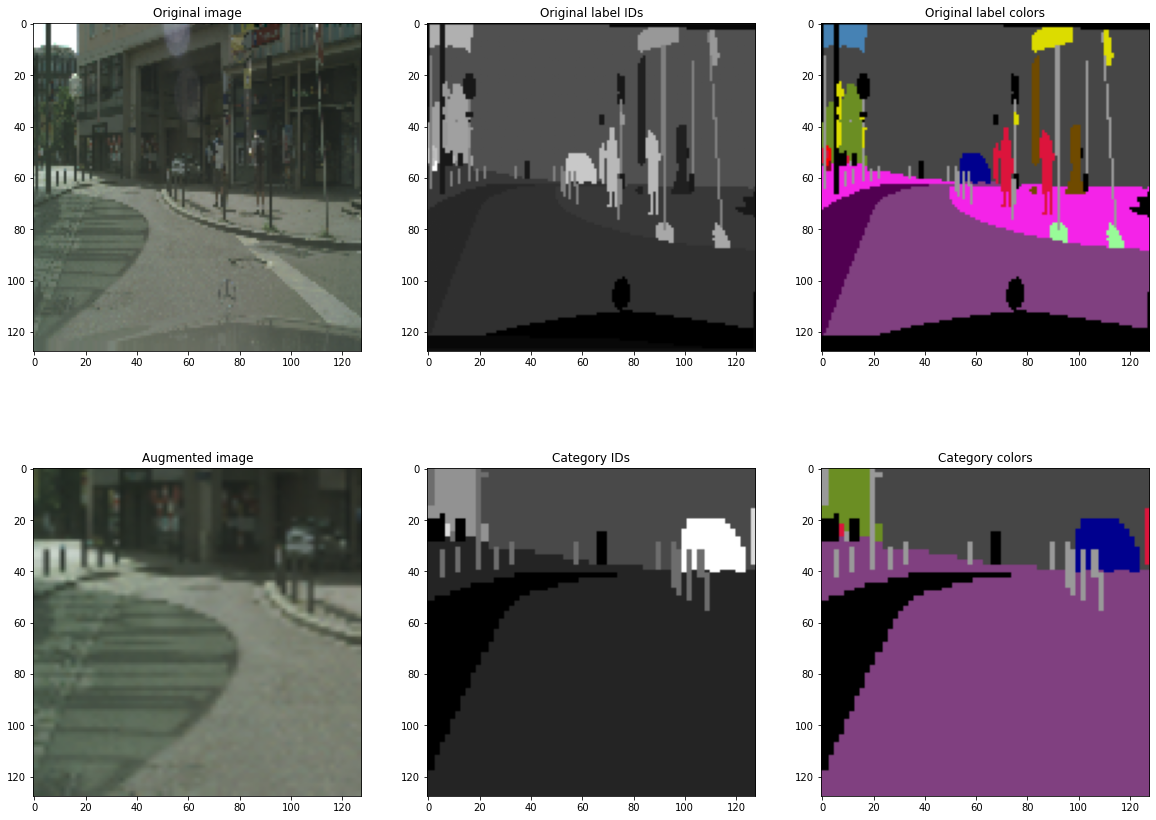

In [143]:
rand_idx = np.random.randint(0, len(train_input_img_paths))


# Subplot
fig, ax = plt.subplots(
    nrows=2,
    ncols=3,
    figsize=(20, 15),
)

ax[0, 0].title.set_text("Original image")
input_img = load_img(train_input_img_paths[rand_idx], target_size=img_size)
ax[0, 0].imshow(input_img)

ax[0, 1].title.set_text("Original label IDs")
label_ids = load_img(
    train_label_ids_img_paths[rand_idx],
    target_size=img_size,
    color_mode="grayscale",
)
ax[0, 1].imshow(label_ids, cmap="gray")

ax[0, 2].title.set_text("Original label colors")
input_colors = load_img(
    train_label_colors_img_paths[rand_idx], target_size=img_size
)
ax[0, 2].imshow(input_colors)

if augment is not None:
    augmented = augment(
        image=np.array(input_img),
        mask=np.expand_dims(
            cityscapes_label_ids_to_category_ids(np.array(label_ids)),
            2,
        ),
    )

    ax[1, 0].title.set_text("Augmented image")
    ax[1, 0].imshow(augmented["image"])

    category_ids = augmented["mask"]
else:
    category_ids = cityscapes_label_ids_to_category_ids(np.array(label_ids))

ax[1, 1].title.set_text("Category IDs")
ax[1, 1].imshow(category_ids, cmap="gray")

ax[1, 2].title.set_text("Category colors")
category_colors = cityscapes_category_ids_to_category_colors(
    np.squeeze(category_ids)
)
ax[1, 2].imshow(category_colors)

plt.show()


In [22]:
class CityscapesGenerator(Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(
        self,
        batch_size,
        img_size,
        input_img_paths,
        label_ids_img_paths,
        augment=None,
    ):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.label_ids_img_paths = label_ids_img_paths
        self.augment = augment

    def __len__(self):
        return len(self.label_ids_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size

        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype=np.uint8)
        for j, path in enumerate(batch_input_img_paths):
            x[j] = np.array(load_img(path, target_size=self.img_size))

        batch_label_ids_img_paths = self.label_ids_img_paths[
            i : i + self.batch_size
        ]
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype=np.uint8)
        for j, path in enumerate(batch_label_ids_img_paths):
            y[j] = np.expand_dims(
                cityscapes_label_ids_to_category_ids(
                    np.array(
                        load_img(
                            path,
                            target_size=self.img_size,
                            color_mode="grayscale",
                        )
                    )
                ),
                2,
            )

        if augment is not None:
            for j in range(self.batch_size):
                augmented = augment(
                    image=x[j],
                    mask=y[j],
                )
                x[j] = augmented["image"]
                y[j] = augmented["mask"]

        return x, y


class CityscapesViewerCallback(Callback):
    def on_epoch_end(self, epoch=None, logs=None):
        rand_idx = np.random.randint(0, len(test_input_img_paths))

        test_img = np.array(
            load_img(test_input_img_paths[rand_idx], target_size=img_size)
        )
        plt.imshow(test_img)
        plt.show()

        pred = cityscapes_category_ids_to_category_colors(
            np.squeeze(
                np.argmax(
                    self.model.predict(np.expand_dims(test_img, 0)), axis=-1
                )
            )
        )
        plt.imshow(pred)
        plt.show()


class UpdatedMeanIoU(MeanIoU):
    """Custom metric to report the mean IoU over the entire batch.

    See : https://github.com/tensorflow/tensorflow/issues/32875#issuecomment-707316950
    """

    def __init__(
        self, y_true=None, y_pred=None, num_classes=None, name=None, dtype=None
    ):
        super(UpdatedMeanIoU, self).__init__(
            num_classes=num_classes, name=name, dtype=dtype
        )

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.math.argmax(y_pred, axis=-1)
        return super().update_state(y_true, y_pred, sample_weight)


def jaccard_loss(y_true, y_pred, smooth=100.0):
    """
    See : https://towardsdatascience.com/image-segmentation-choosing-the-correct-metric-aa21fd5751af
    """

    y_true = tf.squeeze(tf.one_hot(y_true, num_classes))

    intersection = tf.reduce_sum(y_true * y_pred, axis=-1)
    union = tf.reduce_sum(y_true + y_pred, axis=-1) - intersection
    jac = (intersection + smooth) / (union + smooth)

    return (1 - jac) * smooth


In [23]:
def unet_xception_model(img_size, num_classes, model_name="unet_xception"):
    """Creates a U-Net model with Xception as the encoder.

    See : https://keras.io/examples/vision/oxford_pets_image_segmentation/

    Args:
        img_size: tuple of (height, width)
        num_classes: number of classes to predict

    Returns:
        keras.models.Model
    """
    inputs = Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(
        num_classes, 3, activation="softmax", padding="same"
    )(x)

    # Define the model
    model = Model(inputs=inputs, outputs=outputs, name=model_name)
    return model


# Free up RAM in case the model definition cells were run multiple times
clear_session()

# Build model
if Path(model_path).exists():
    model = load_model(
        Path(model_path, "model"),
        custom_objects={
            "UpdatedMeanIoU": UpdatedMeanIoU,
            "jaccard_loss": jaccard_loss,
        },
    )
else:
    model = unet_xception_model(img_size, num_classes)

model.summary()


Model: "unet_xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 32)   896         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 64, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                      

Loading model from ../results/unet_xception_128/checkpoint.h5
Epoch 1/100
92/92 [==============================] - ETA: 0s - loss: 0.5853 - MeanIoU: 0.2718
Epoch 1: val_loss improved from inf to 0.60060, saving model to ../results/unet_xception_128/checkpoint.h5


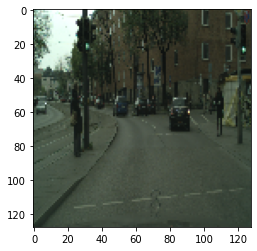

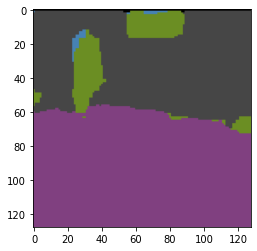

92/92 [==============================] - 379s 4s/step - loss: 0.5853 - MeanIoU: 0.2718 - val_loss: 0.6006 - val_MeanIoU: 0.2914 - lr: 0.0010
Epoch 2/100
92/92 [==============================] - ETA: 0s - loss: 0.4845 - MeanIoU: 0.3884
Epoch 2: val_loss improved from 0.60060 to 0.51897, saving model to ../results/unet_xception_128/checkpoint.h5


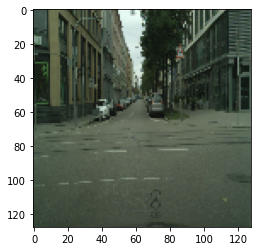

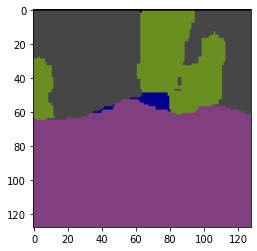

92/92 [==============================] - 361s 4s/step - loss: 0.4845 - MeanIoU: 0.3884 - val_loss: 0.5190 - val_MeanIoU: 0.3748 - lr: 0.0010
Epoch 3/100
92/92 [==============================] - ETA: 0s - loss: 0.4538 - MeanIoU: 0.4150
Epoch 3: val_loss did not improve from 0.51897

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.


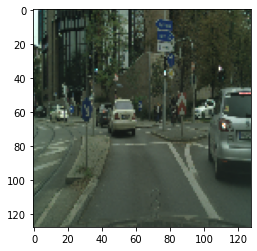

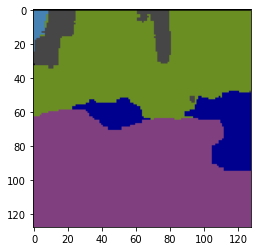

92/92 [==============================] - 339s 4s/step - loss: 0.4538 - MeanIoU: 0.4150 - val_loss: 0.5192 - val_MeanIoU: 0.3746 - lr: 0.0010
Epoch 4/100
92/92 [==============================] - ETA: 0s - loss: 0.4210 - MeanIoU: 0.4375
Epoch 4: val_loss did not improve from 0.51897

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.


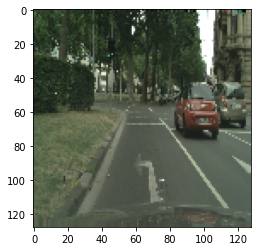

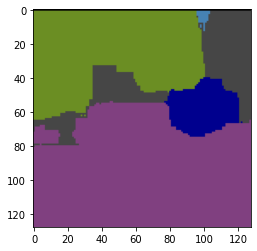

92/92 [==============================] - 340s 4s/step - loss: 0.4210 - MeanIoU: 0.4375 - val_loss: 0.5299 - val_MeanIoU: 0.3863 - lr: 5.0000e-04
Epoch 5/100
92/92 [==============================] - ETA: 0s - loss: 0.4024 - MeanIoU: 0.4507
Epoch 5: val_loss improved from 0.51897 to 0.48321, saving model to ../results/unet_xception_128/checkpoint.h5


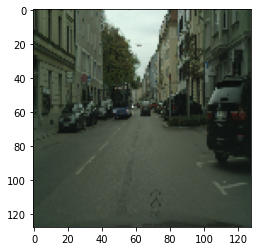

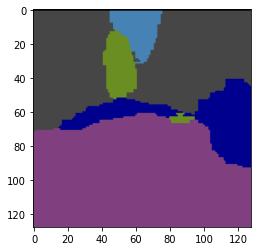

92/92 [==============================] - 336s 4s/step - loss: 0.4024 - MeanIoU: 0.4507 - val_loss: 0.4832 - val_MeanIoU: 0.4125 - lr: 2.5000e-04
Epoch 6/100
92/92 [==============================] - ETA: 0s - loss: 0.3956 - MeanIoU: 0.4556
Epoch 6: val_loss did not improve from 0.48321

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.


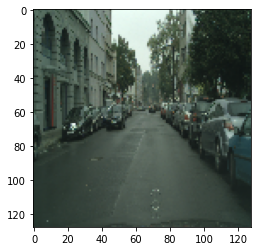

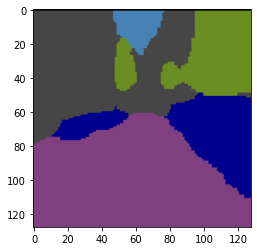

92/92 [==============================] - 336s 4s/step - loss: 0.3956 - MeanIoU: 0.4556 - val_loss: 0.4904 - val_MeanIoU: 0.4089 - lr: 2.5000e-04
Epoch 7/100
92/92 [==============================] - ETA: 0s - loss: 0.3864 - MeanIoU: 0.4622
Epoch 7: val_loss improved from 0.48321 to 0.47932, saving model to ../results/unet_xception_128/checkpoint.h5


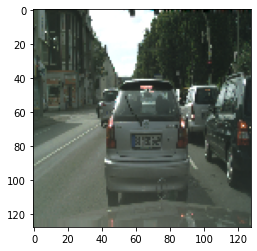

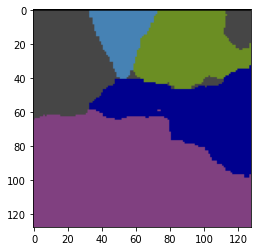

92/92 [==============================] - 353s 4s/step - loss: 0.3864 - MeanIoU: 0.4622 - val_loss: 0.4793 - val_MeanIoU: 0.4156 - lr: 1.2500e-04
Epoch 8/100
92/92 [==============================] - ETA: 0s - loss: 0.3822 - MeanIoU: 0.4655
Epoch 8: val_loss improved from 0.47932 to 0.46948, saving model to ../results/unet_xception_128/checkpoint.h5


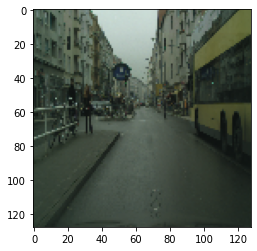

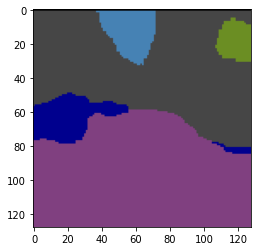

92/92 [==============================] - 339s 4s/step - loss: 0.3822 - MeanIoU: 0.4655 - val_loss: 0.4695 - val_MeanIoU: 0.4223 - lr: 1.2500e-04
Epoch 9/100
92/92 [==============================] - ETA: 0s - loss: 0.3780 - MeanIoU: 0.4685
Epoch 9: val_loss improved from 0.46948 to 0.46503, saving model to ../results/unet_xception_128/checkpoint.h5


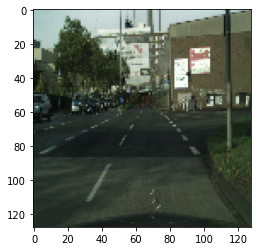

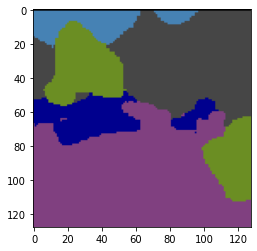

92/92 [==============================] - 337s 4s/step - loss: 0.3780 - MeanIoU: 0.4685 - val_loss: 0.4650 - val_MeanIoU: 0.4249 - lr: 1.2500e-04
Epoch 10/100
92/92 [==============================] - ETA: 0s - loss: 0.3745 - MeanIoU: 0.4710
Epoch 10: val_loss improved from 0.46503 to 0.46292, saving model to ../results/unet_xception_128/checkpoint.h5


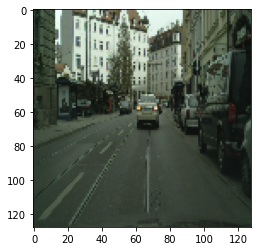

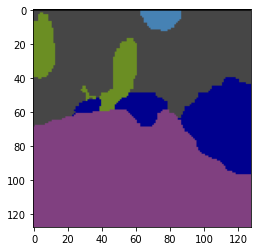

92/92 [==============================] - 340s 4s/step - loss: 0.3745 - MeanIoU: 0.4710 - val_loss: 0.4629 - val_MeanIoU: 0.4247 - lr: 1.2500e-04
Epoch 11/100
92/92 [==============================] - ETA: 0s - loss: 0.3710 - MeanIoU: 0.4737
Epoch 11: val_loss did not improve from 0.46292

Epoch 11: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.


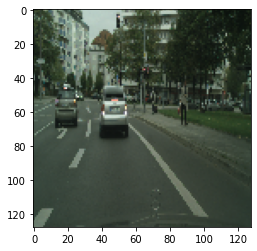

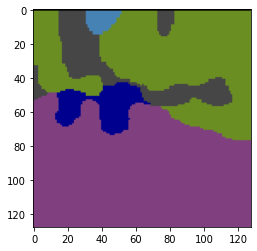

92/92 [==============================] - 345s 4s/step - loss: 0.3710 - MeanIoU: 0.4737 - val_loss: 0.4647 - val_MeanIoU: 0.4253 - lr: 1.2500e-04
Epoch 12/100
92/92 [==============================] - ETA: 0s - loss: 0.3660 - MeanIoU: 0.4774
Epoch 12: val_loss did not improve from 0.46292

Epoch 12: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.


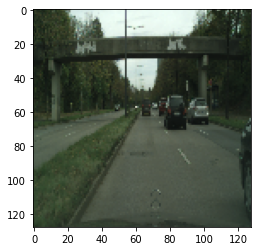

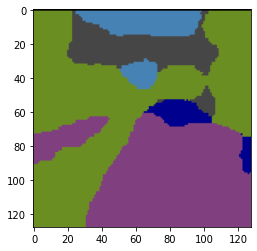

92/92 [==============================] - 359s 4s/step - loss: 0.3660 - MeanIoU: 0.4774 - val_loss: 0.4640 - val_MeanIoU: 0.4257 - lr: 6.2500e-05
Epoch 13/100
92/92 [==============================] - ETA: 0s - loss: 0.3631 - MeanIoU: 0.4795
Epoch 13: val_loss improved from 0.46292 to 0.46128, saving model to ../results/unet_xception_128/checkpoint.h5


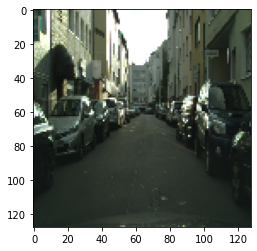

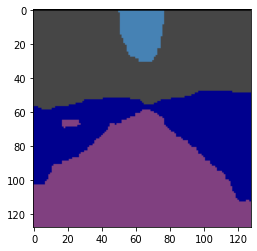

92/92 [==============================] - 363s 4s/step - loss: 0.3631 - MeanIoU: 0.4795 - val_loss: 0.4613 - val_MeanIoU: 0.4266 - lr: 3.1250e-05
Epoch 14/100
92/92 [==============================] - ETA: 0s - loss: 0.3617 - MeanIoU: 0.4805
Epoch 14: val_loss improved from 0.46128 to 0.46065, saving model to ../results/unet_xception_128/checkpoint.h5

Epoch 14: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.


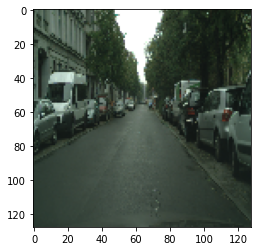

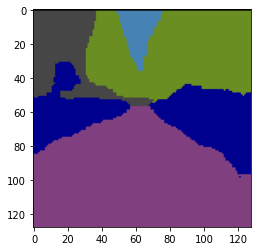

92/92 [==============================] - 365s 4s/step - loss: 0.3617 - MeanIoU: 0.4805 - val_loss: 0.4607 - val_MeanIoU: 0.4263 - lr: 3.1250e-05
Epoch 15/100
92/92 [==============================] - ETA: 0s - loss: 0.3604 - MeanIoU: 0.4815
Epoch 15: val_loss improved from 0.46065 to 0.46030, saving model to ../results/unet_xception_128/checkpoint.h5

Epoch 15: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.


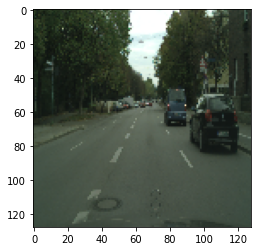

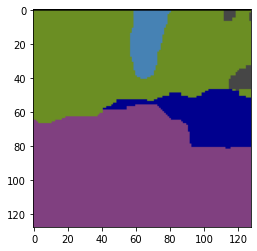

92/92 [==============================] - 356s 4s/step - loss: 0.3604 - MeanIoU: 0.4815 - val_loss: 0.4603 - val_MeanIoU: 0.4269 - lr: 1.5625e-05
Epoch 16/100
92/92 [==============================] - ETA: 0s - loss: 0.3596 - MeanIoU: 0.4821
Epoch 16: val_loss did not improve from 0.46030

Epoch 16: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.


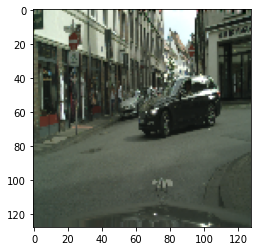

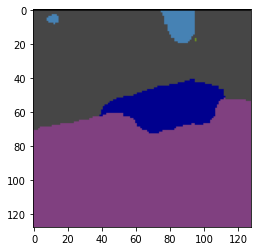

92/92 [==============================] - 360s 4s/step - loss: 0.3596 - MeanIoU: 0.4821 - val_loss: 0.4606 - val_MeanIoU: 0.4265 - lr: 7.8125e-06
Epoch 17/100
92/92 [==============================] - ETA: 0s - loss: 0.3593 - MeanIoU: 0.4824
Epoch 17: val_loss improved from 0.46030 to 0.46022, saving model to ../results/unet_xception_128/checkpoint.h5


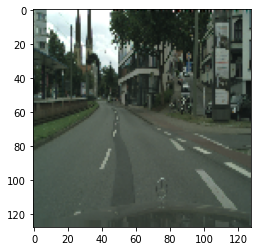

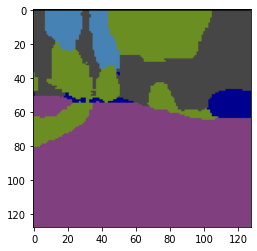

92/92 [==============================] - 346s 4s/step - loss: 0.3593 - MeanIoU: 0.4824 - val_loss: 0.4602 - val_MeanIoU: 0.4267 - lr: 3.9063e-06
Epoch 18/100
92/92 [==============================] - ETA: 0s - loss: 0.3591 - MeanIoU: 0.4825
Epoch 18: val_loss did not improve from 0.46022

Epoch 18: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.


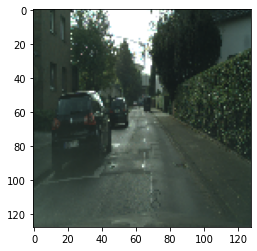

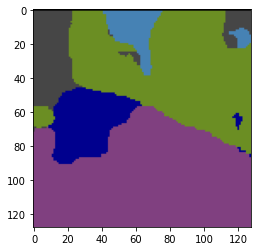

92/92 [==============================] - 347s 4s/step - loss: 0.3591 - MeanIoU: 0.4825 - val_loss: 0.4604 - val_MeanIoU: 0.4265 - lr: 3.9063e-06
Epoch 19/100
92/92 [==============================] - ETA: 0s - loss: 0.3589 - MeanIoU: 0.4827
Epoch 19: val_loss did not improve from 0.46022

Epoch 19: ReduceLROnPlateau reducing learning rate to 9.765625463842298e-07.


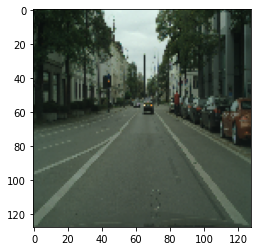

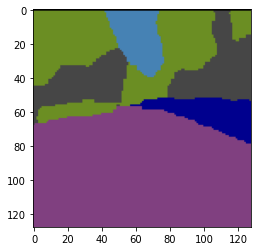

92/92 [==============================] - 349s 4s/step - loss: 0.3589 - MeanIoU: 0.4827 - val_loss: 0.4606 - val_MeanIoU: 0.4263 - lr: 1.9531e-06
Epoch 20/100
92/92 [==============================] - ETA: 0s - loss: 0.3588 - MeanIoU: 0.4828
Epoch 20: val_loss did not improve from 0.46022

Epoch 20: ReduceLROnPlateau reducing learning rate to 4.882812731921149e-07.
Restoring model weights from the end of the best epoch: 17.


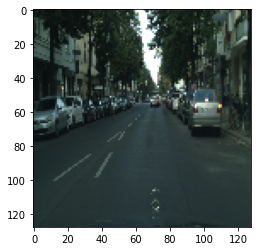

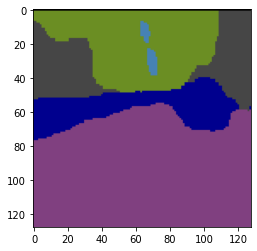

92/92 [==============================] - 348s 4s/step - loss: 0.3588 - MeanIoU: 0.4828 - val_loss: 0.4606 - val_MeanIoU: 0.4263 - lr: 9.7656e-07
Epoch 20: early stopping
INFO:tensorflow:Assets written to: ../results/unet_xception_128/model/assets


In [24]:
# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
model.compile(
    optimizer="adam",
    loss=jaccard_loss, # "sparse_categorical_crossentropy",
    metrics=[
        UpdatedMeanIoU(name="MeanIoU", num_classes=num_classes), # https://ilmonteux.github.io/2019/05/10/segmentation-metrics.html
    ],
)

model_checkpoint_path = Path(model_path, "checkpoint.h5")
if model_checkpoint_path.exists():
    print("Loading model from {}".format(model_checkpoint_path))
    model.load_weights(str(model_checkpoint_path))

# Train the model, doing validation at the end of each epoch.
model.fit(
    CityscapesGenerator(
        batch_size, img_size, train_input_img_paths, train_label_ids_img_paths
    ),
    validation_data=CityscapesGenerator(
        batch_size, img_size, val_input_img_paths, val_label_ids_img_paths
    ),
    epochs=100,
    callbacks=[
        ModelCheckpoint(
            model_checkpoint_path,
            save_best_only=True,
            verbose=1,
        ),
        ReduceLROnPlateau(
            patience=1,
            factor=0.5,
            min_delta=1e-3,
            min_lr=1e-9,
            verbose=1,
        ),
        EarlyStopping(
            patience=3,
            restore_best_weights=True,
            min_delta=1e-5,
            verbose=1,
        ),
        TensorBoard(log_dir=Path(model_path, "logs")),
        CityscapesViewerCallback(),
    ],
    workers=4,
    use_multiprocessing=True,
)

model.save(Path(model_path, "model"))

# Initial training time (1 worker on CPU) : ~90 min // ~7 min per epoch


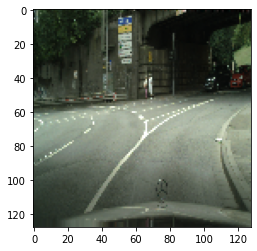

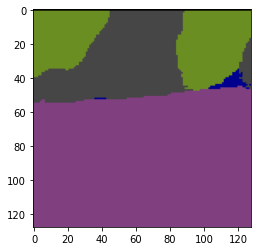

In [25]:
rand_idx = np.random.randint(0, len(test_input_img_paths))

test_img = np.array(load_img(test_input_img_paths[rand_idx], target_size=img_size))
plt.imshow(test_img)
plt.show()

pred = cityscapes_category_ids_to_category_colors(
    np.squeeze(np.argmax(model.predict(np.expand_dims(test_img, 0)), axis=-1))
)
plt.imshow(pred)
plt.show()
